# Step 5 : Mini-Taxonomy of Definitions

**Goal**: The goal here is to extract and classify definitions of "Agentic AI" in the corpus

**Hybrid approach**:
We can explore several approaches:
1. **Semi-automatic extraction** - Identify definition paragraphs
2. **Manual classification** - Group into conceptual categories
3. **Visualization** - Tables and diagrams (treemap, sunburst)

**Expected categories**: Based on the PDFs selected we can expect these categories:
- AI as Copilots/Assistants
- AI as Autonomous Workers
- AI as Multi-Agent Ecosystems/Orchestrators
- AI as Governance/Risk Challenges

**Output**: Taxonomy of definitions + report visualizations

## 🔧 Setup Config & Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')
import json
import re
from pathlib import Path
from collections import Counter, defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import sent_tokenize
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
%matplotlib inline
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10

## 📂 Load processed corpus

In [2]:
PROJECT_ROOT=Path.cwd().parent
PROCESSED_DATA=PROJECT_ROOT/"data"/"processed"
TEXTS_DIR=PROCESSED_DATA/"texts"
METADATA_FILE=PROCESSED_DATA/"metadata"/"corpus_metadata.json"
TAXONOMY_DIR = PROCESSED_DATA/"taxonomy"
TAXONOMY_DIR.mkdir(exist_ok=True)
print(f"current folder: {TAXONOMY_DIR}")

current folder: c:\Users\antoi\Desktop\project_datascience\language-of-autonomy\data\processed\taxonomy


In [3]:
texts = {}
with open(METADATA_FILE, 'r', encoding='utf-8') as f:
    metadata=json.load(f)
for doc_id in metadata.keys():
    text_file=TEXTS_DIR/f"{doc_id}.txt"
    if text_file.exists():
        with open(text_file,'r', encoding='utf-8') as f:
            texts[doc_id]=f.read()

print(f"{len(texts)} documents loaded")

20 documents loaded


we map each document to its source type thanks to the metadata

In [4]:
doc_to_source={doc_id: metadata[doc_id]['source_type'] for doc_id in texts.keys()}

## Text cleaning

We manually create stop words for words that we found irrelevant, or adding noise for a future analysis

In [5]:
CUSTOM_STOPWORDS = {
   
    'executive', 'summary', 'introduction', 'conclusion', 'chapter', 'section',
    'figure', 'table', 'appendix', 'page', 'report', 'study', 'analysis',
    'et', 'al', 'inc', 'ltd', 'corp', 'eg', 'ie', 'etc',
    
    #'2023', '2024', '2025'  
   
    'cid', 'new', 'datum', 'across', 'many', 'must', 'year', 'like', 'non',
    'aaron', 'end', 'east', 'london', 'school', 'deputy', 'minister', 'party',

    # people and random stuff
    'atsushi', 'kanehira', 'david', 'crawford', 'anne', 'hoecker', 'lari', 'inen', 'wang',
    'fuet', 'ufureture', 'hector', 'rivoire', 'valentino', 'valentini', 'eth', 'gth', 'kazuhiro', 'sasabuchi',
    'sshhaappinign', 'gth', 'movillo', 'matta', 'naoki', 'wake', 'usman', 'ikhlaq',
    'josefina', 'movillo', 'almudena', 'benjamin', 'chino', 'mart', 'castro', 'michelle', 'gill',
    'syed', 'ali', 'laurent', 'pierre', 'baculard', 'bharat', 'bansal', 'ann', 'bosche', 'peter', 'bowen', 'steven', 'breeden', 
    'alessandro', 'cannarsi', 'willy', 'chang', 'matthew', 'crupi', 'arjun', 'dutt', 'greg', 'fiore', 'jonathan',
    'frick', 'pascal', 'gautheron', 'adam', 'haller', 'hanbury', 'karen', 'harris', 'jonny', 'holiday', 'mark', 'kovac', 
    'tamara', 'lewis', 'lipman', 'neil', 'malik', 'justin', 'murphy', 'christopher', 'perry', 'bill', 'radzevych', 'paul',
    'dana', 'aulanier', 'chris', 'bell', 'purna', 'doddapaneni', 'stephen', 'gabe', 'dunn', 'aaron', 'ryan', 'petranovich', 'tanvee', 'rao',
    'renno', 'michael', 'schallehn', 'jennifer', 'smith', 'ravi', 'vijayaraghavan', 'jue', 'chuck', 'whitten',
    
    # sources
    'bain', 'bcg', 'mckinsey', 'pwc', 'deloitte', 'mit', 'stanford', 'harvard', 'google',
    'microsoft', 'openai', 'wef', 'oecd', 'undp', 'iti', 'boston', 'sloan', 'arxiv'
}

print(f"{len(CUSTOM_STOPWORDS)} custom stopwords")

161 custom stopwords


In [6]:
def clean_text(text):
    """
    Clean the text in depth.
    
    Steps:
    1. Convert to lowercase
    2. Remove URLs and emails
    3. Remove numbers
    4. Remove excessive punctuation
    5. Normalize spaces
    """
    text=text.lower()
    # remove URLs
    text=re.sub(r'http\S+|www\.\S+','',text)
    # remove emails
    text=re.sub(r'\S+@\S+','',text)  
    # remove numbers 
    text=re.sub(r'\b\d+\b','',text)
    # remove special characters and punctuation 
    # text=re.sub(r'[^\w\s\'-]', ' ', text)  
    # multiple spaces
    text=re.sub(r'\s+',' ',text)
    text = re.sub(r"[^a-z\s]", " ", text)
    for word in CUSTOM_STOPWORDS:
        text = re.sub(r"word", "", text)
    text = text.strip()
    
    return text

## Semi-automatic extraction of definition

### Extraction strategy

Here, we will extract the definitions of agentic AI, autonomous agents, and AI agents from the text. To do so, we will identify the phrases/paragraphs which:
1. Contain the key terms: "agentic ai", "ai agent", "autonomous agent"
2. Use definition markers: "is", "are", "defined as", "refers to", "means"
3. Are in the first sections (introduction, definitions)

In [7]:
def extract_definition_candidates(text, doc_id):
    """
    Extract candidate phrases as definitions.
    
    Criterias:
    - Contains key terms (agentic, agent, autonomous)
    - Contains definitional markers
    - Reasonable length (30-300 words)
    """
    sentences=sent_tokenize(text)
    
    # key terms to search
    key_terms = [
        r'\bagentic\s+ai\b',
        r'\bai\s+agent[s]?\b',
        r'\bautonomous\s+agent[s]?\b',
        r'\bagentic\s+system[s]?\b',
        r'\bagent[s]?\s+are\b',
        r'\bagent[s]?\s+is\b'
    ]
    
    # definitional markers
    def_markers = [
        r'\bis\s+defined\s+as\b',
        r'\bare\s+defined\s+as\b',
        r'\brefers?\s+to\b',
        r'\bmeans?\b',
        r'\bcan\s+be\s+understood\s+as\b',
        r'\bcharacterized\s+by\b',
        r'\bconsists?\s+of\b',
        r'\benables?\b',
        r'\bcapable\s+of\b'
    ]
    
    candidates = []
    
    for i, sentence in enumerate(sentences):
        sentence_lower = sentence.lower()
        
        # check key terms presence
        has_key_term = any(re.search(pattern, sentence_lower) for pattern in key_terms)
        
        if not has_key_term:
            continue
        
        # check definitional markers presence
        has_def_marker = any(re.search(pattern, sentence_lower) for pattern in def_markers)
        
        # check length
        word_count = len(sentence.split())
        
        # Score phrase
        score = 0
        if has_key_term:
            score += 2
        if has_def_marker:
            score += 3
        if 30 <= word_count <= 300:
            score += 1
        if i < len(sentences) * 0.3:  #first 30%
            score += 1
        
        if score >= 3:
            # Extract next phrase for context
            context = sentence
            if i + 1 < len(sentences):
                context += " " + sentences[i + 1]
            
            candidates.append({
                'doc_id': doc_id,
                'sentence_id': i,
                'text': sentence.strip(),
                'context': context.strip(),
                'word_count': word_count,
                'score': score,
                'has_def_marker': has_def_marker
            })
    
    return candidates

In [8]:
all_candidates=[]

for doc_id, text in texts.items():
    candidates = extract_definition_candidates(text, doc_id)
    all_candidates.extend(candidates)
    
    filename = metadata[doc_id]['filename']
    print(f"\n{filename}")
    print(f"{len(candidates)} potential definitions found")

print(f"\nTotal: {len(all_candidates)} candidate definitions extracted")


Bain_report_technology_report_2025.pdf
18 potential definitions found

BCG_AI_Agents_2025.pdf
27 potential definitions found

Deloitte_The_business_imperative_for_Agentic_AI_2025.pdf
48 potential definitions found

Google_Agentic_AI_TAM_Analysis_2025.pdf
126 potential definitions found

Google_The_ROI_of_AI_2025.pdf
10 potential definitions found

Harvard_Designing_a_Successful_Agentic_AI_System_2025.pdf
31 potential definitions found

ITI_Understanding_Agentic_AI_Policy_Guide_2025.pdf
86 potential definitions found

McKinsey_Empowering_advanced_industries_with_agentic_AI_2025.pdf
25 potential definitions found

McKinsey_The_agentic_organization_contours_of_the_next_paradigm_for_the_AI_era_2025.pdf
14 potential definitions found

McKinsey_What_is_an_AI_Agent_2025.pdf
33 potential definitions found

Microsoft_Agent_AI_Towards_a_Holistic_Intelligence_2025.pdf
5 potential definitions found

MIT_Reimagining_the_future_of_banking_with_agentic_AI_2025.pdf
30 potential definitions found

MIT

### Extracted definitions overview

let's check the definition through a dataframe

In [9]:
df_candidates=pd.DataFrame(all_candidates)

# add metadata
df_candidates['filename'] = df_candidates['doc_id'].map(
    lambda x: metadata[x]['filename']
)
df_candidates['source_type'] = df_candidates['doc_id'].map(doc_to_source)

df_candidates = df_candidates.sort_values('score', ascending=False)

print("TOP 10 CANDIDATE DEFINITIONS (by score)")
for i, row in df_candidates.head(10).iterrows():
    print(f"\n{row['filename']} (Score: {row['score']})")
    print(f"  {row['text'][:200]}...")

TOP 10 CANDIDATE DEFINITIONS (by score)

MIT_Reimagining_the_future_of_banking_with_agentic_AI_2025.pdf (Score: 7)
  More than half of executives say agentic AI how their firm operates is going to make the difference systems are highly capable of improving fraud detection between the firms that succeed and those tha...

McKinsey_What_is_an_AI_Agent_2025.pdf (Score: 7)
  “Today, the joint human-plus-machine outcome can generate great quality and great productivity.” Recent developments in short- and long-term memory structures have enabled these agents to better perso...

WEF_AI_Agents_in_Action_Foundations_for_Evaluation_and_Governance_2025.pdf (Score: 7)
  ranges from simple command-response systems to AI Agents in Action: Foundations for Evaluation and Governance 13 Establishing agents capable of planning and executing actions Autonomy and authority ca...

ITI_Understanding_Agentic_AI_Policy_Guide_2025.pdf (Score: 7)
  The Workplace Shifts: The widespread adoption rapid pace of AI de

## Manual classification of definitions

For each candidate definition we assign a category

In [10]:
TAXONOMY_CATEGORIES = {
    'copilot': {
        'label': 'AI as Copilots/Assistants',
        'description': 'AI agents that augment human work, provide suggestions, collaborate with users',
        'keywords': ['copilot', 'assistant', 'augment', 'support', 'collaborate', 'suggest', 'help']
    },
    'autonomous_worker': {
        'label': 'AI as Autonomous Workers',
        'description': 'AI agents that independently execute tasks with minimal human intervention',
        'keywords': ['autonomous', 'independent', 'execute', 'automate', 'replace', 'perform']
    },
    'orchestrator': {
        'label': 'AI as Multi-Agent Ecosystems/Orchestrators',
        'description': 'AI systems coordinating multiple agents, workflows, or complex processes',
        'keywords': ['orchestrate', 'coordinate', 'multi-agent', 'ecosystem', 'workflow', 'multi-step', 'planning']
    },
    'governance': {
        'label': 'AI as Governance/Risk Challenges',
        'description': 'AI agents framed through ethical, regulatory, or risk management lens',
        'keywords': ['governance', 'risk', 'compliance', 'regulation', 'ethics', 'safety', 'alignment', 'control']
    },
    'other': {
        'label': 'Other/Uncategorized',
        'description': 'Definitions that don\'t fit main categories',
        'keywords': []
    }
}

print("\nTaxonomy categories:")
for cat_id, cat_info in TAXONOMY_CATEGORIES.items():
    print(f"\n{cat_info['label']}")
    print(f"{cat_info['description']}")
    print(f"Key words: {', '.join(cat_info['keywords'][:5])}")


Taxonomy categories:

AI as Copilots/Assistants
AI agents that augment human work, provide suggestions, collaborate with users
Key words: copilot, assistant, augment, support, collaborate

AI as Autonomous Workers
AI agents that independently execute tasks with minimal human intervention
Key words: autonomous, independent, execute, automate, replace

AI as Multi-Agent Ecosystems/Orchestrators
AI systems coordinating multiple agents, workflows, or complex processes
Key words: orchestrate, coordinate, multi-agent, ecosystem, workflow

AI as Governance/Risk Challenges
AI agents framed through ethical, regulatory, or risk management lens
Key words: governance, risk, compliance, regulation, ethics

Other/Uncategorized
Definitions that don't fit main categories
Key words: 


### Semi-automatic classification (First try)

We use the key words to assign a category

In [11]:
def suggest_category(text):
    """
    Suggest a category based on key-words.
    """
    text_lower = text.lower()
    
    scores = {}
    for cat_id, cat_info in TAXONOMY_CATEGORIES.items():
        if cat_id == 'other':
            continue
        
        score = sum(1 for keyword in cat_info['keywords'] if keyword in text_lower)
        scores[cat_id] = score
    
    if max(scores.values()) == 0:
        return 'other', 0
    
    suggested_cat = max(scores.items(), key=lambda x: x[1])[0]
    confidence = scores[suggested_cat]
    
    return suggested_cat, confidence

In [12]:
# Suggest cats
df_candidates['suggested_category'] = df_candidates.apply(
    lambda row: suggest_category(row['text'])[0], axis=1
)
df_candidates['category_confidence'] = df_candidates.apply(
    lambda row: suggest_category(row['text'])[1], axis=1
)

In [13]:
print("SUGGESTION FOR CLASSIFICATION")
for cat_id in ['copilot', 'autonomous_worker', 'orchestrator', 'governance', 'other']:
    count = (df_candidates['suggested_category'] == cat_id).sum()
    print(f"  {TAXONOMY_CATEGORIES[cat_id]['label']:45} : {count:2} definitions")

SUGGESTION FOR CLASSIFICATION
  AI as Copilots/Assistants                     : 79 definitions
  AI as Autonomous Workers                      : 92 definitions
  AI as Multi-Agent Ecosystems/Orchestrators    : 65 definitions
  AI as Governance/Risk Challenges              : 97 definitions
  Other/Uncategorized                           : 417 definitions


### Export for manual classification

In [14]:
# Create CSV file for manual checking
review_df = df_candidates[[
    'filename', 'source_type', 'text', 'context', 
    'suggested_category', 'category_confidence'
]].copy()

# Add empty column for final category (to be filled manually)
review_df['final_category'] = review_df['suggested_category']
review_df['notes'] = ''
review_df['keep'] = True  # To mark definitions to keep

# Save
review_file = TAXONOMY_DIR / 'definitions_for_manual_review.csv'
review_df.to_csv(review_file, index=False, encoding='utf-8')

print(f"\n File for manual review: {review_file}")
print("\n  MANUAL REVIEW REQUIRED:")
print("   1. Open the CSV file in Excel/Google Sheets")
print("   2. Read each definition")
print("   3. Correct the 'final_category' column if necessary")
print("   4. Set 'keep' to False for irrelevant definitions")
print("   5. Add notes if needed")
print("   6. Save the file")


 File for manual review: c:\Users\antoi\Desktop\project_datascience\language-of-autonomy\data\processed\taxonomy\definitions_for_manual_review.csv

  MANUAL REVIEW REQUIRED:
   1. Open the CSV file in Excel/Google Sheets
   2. Read each definition
   3. Correct the 'final_category' column if necessary
   4. Set 'keep' to False for irrelevant definitions
   5. Add notes if needed
   6. Save the file


## Manually reviewed candidate definitions loading

In [15]:
# After manually reviewing the CSV
reviewed_file = TAXONOMY_DIR / 'definitions_for_manual_review.csv'

if reviewed_file.exists():
    df_reviewed = pd.read_csv(reviewed_file)
    df_definitions = df_reviewed[df_reviewed['keep'] == True].copy()
    
    print(f"Manual results loaded: {len(df_definitions)} definitions validated")
    
    category_col = 'final_category'
else:
    print("Reviewed file not found. Using automatic classification.")
    df_definitions = df_candidates.copy()
    df_definitions['final_category'] = df_definitions['suggested_category']
    category_col = 'final_category'

# clean invalid categories
valid_categories = list(TAXONOMY_CATEGORIES.keys())
df_definitions[category_col] = df_definitions[category_col].apply(
    lambda x: x if x in valid_categories else 'other'
)

Manual results loaded: 750 definitions validated


In [16]:
print(f"\nDefinition final distribution:")
for cat_id in ['copilot', 'autonomous_worker', 'orchestrator', 'governance', 'other']:
    count = (df_definitions[category_col] == cat_id).sum()
    pct = count / len(df_definitions) * 100 if len(df_definitions) > 0 else 0
    print(f"  {TAXONOMY_CATEGORIES[cat_id]['label']:45} : {count:2} ({pct:5.1f}%)")


Definition final distribution:
  AI as Copilots/Assistants                     : 79 ( 10.5%)
  AI as Autonomous Workers                      : 92 ( 12.3%)
  AI as Multi-Agent Ecosystems/Orchestrators    : 65 (  8.7%)
  AI as Governance/Risk Challenges              : 97 ( 12.9%)
  Other/Uncategorized                           : 417 ( 55.6%)


## Definitions Table

In [17]:
table_data=[]

for _, row in df_definitions.iterrows():
    table_data.append({
        'Report': row['filename'][:40],
        'Source Type': row['source_type'],
        'Category': TAXONOMY_CATEGORIES[row[category_col]]['label'],
        'Definition': row['text'][:150] + '...' if len(row['text']) > 150 else row['text']
    })

df_table=pd.DataFrame(table_data)
df_table.head()

,Report,Source Type,Category,Definition
0,MIT_Reimagining_the_future_of_banking_wi,Academic,Other/Uncategorized,More than half of executives say agentic AI ho...
1,McKinsey_What_is_an_AI_Agent_2025.pdf,Consulting,Other/Uncategorized,"“Today, the joint human-plus-machine outcome c..."
2,WEF_AI_Agents_in_Action_Foundations_for_,Policy,AI as Autonomous Workers,ranges from simple command-response systems to...
3,ITI_Understanding_Agentic_AI_Policy_Guid,Policy,Other/Uncategorized,The Workplace Shifts: The widespread adoption ...
4,McKinsey_Empowering_advanced_industries_,Consulting,AI as Copilots/Assistants,"By automating workflows, enhancing quality con..."


In [18]:
df_table.to_csv(TAXONOMY_DIR/'definitions_table.csv', index=False, encoding='utf-8')
print(f"Table saved to: {TAXONOMY_DIR / 'definitions_table.csv'}")

Table saved to: c:\Users\antoi\Desktop\project_datascience\language-of-autonomy\data\processed\taxonomy\definitions_table.csv


In [40]:
print("\nExamples per categories:\n")

for cat_id in ['copilot', 'autonomous_worker', 'orchestrator', 'governance']:
    cat_label = TAXONOMY_CATEGORIES[cat_id]['label']
    cat_defs = df_table[df_table['Category'] == cat_label]
    
    if len(cat_defs) == 0:
        continue
    
    print(f"{'─'*70}")
    print(f"{cat_label}")
    print(f"{'─'*70}")
    
    for _, row in cat_defs.head(2).iterrows():
        print(f"\n  {row['Report']}")
        print(f"     {row['Definition']}")
    
    print()


Examples per categories:

──────────────────────────────────────────────────────────────────────
AI as Copilots/Assistants
──────────────────────────────────────────────────────────────────────

  McKinsey_Empowering_advanced_industries_
     By automating workflows, enhancing quality control, and driving innovation, agentic AI enables companies to reengineer end-to-end processes, supportin...

  WEF_AI_Agents_in_Action_Foundations_for_
     FIGURE 3 Illustration of MCP-based agent communication Overview of MCP AI agent 1 AI agent 2 MCP MCP MCP 1 client client client messaging database dat...

──────────────────────────────────────────────────────────────────────
AI as Autonomous Workers
──────────────────────────────────────────────────────────────────────

  WEF_AI_Agents_in_Action_Foundations_for_
     ranges from simple command-response systems to AI Agents in Action: Foundations for Evaluation and Governance 13 Establishing agents capable of planni...

  Google_Agentic_AI_TAM_Ana

## Taxonomy visualization

### Global distribution

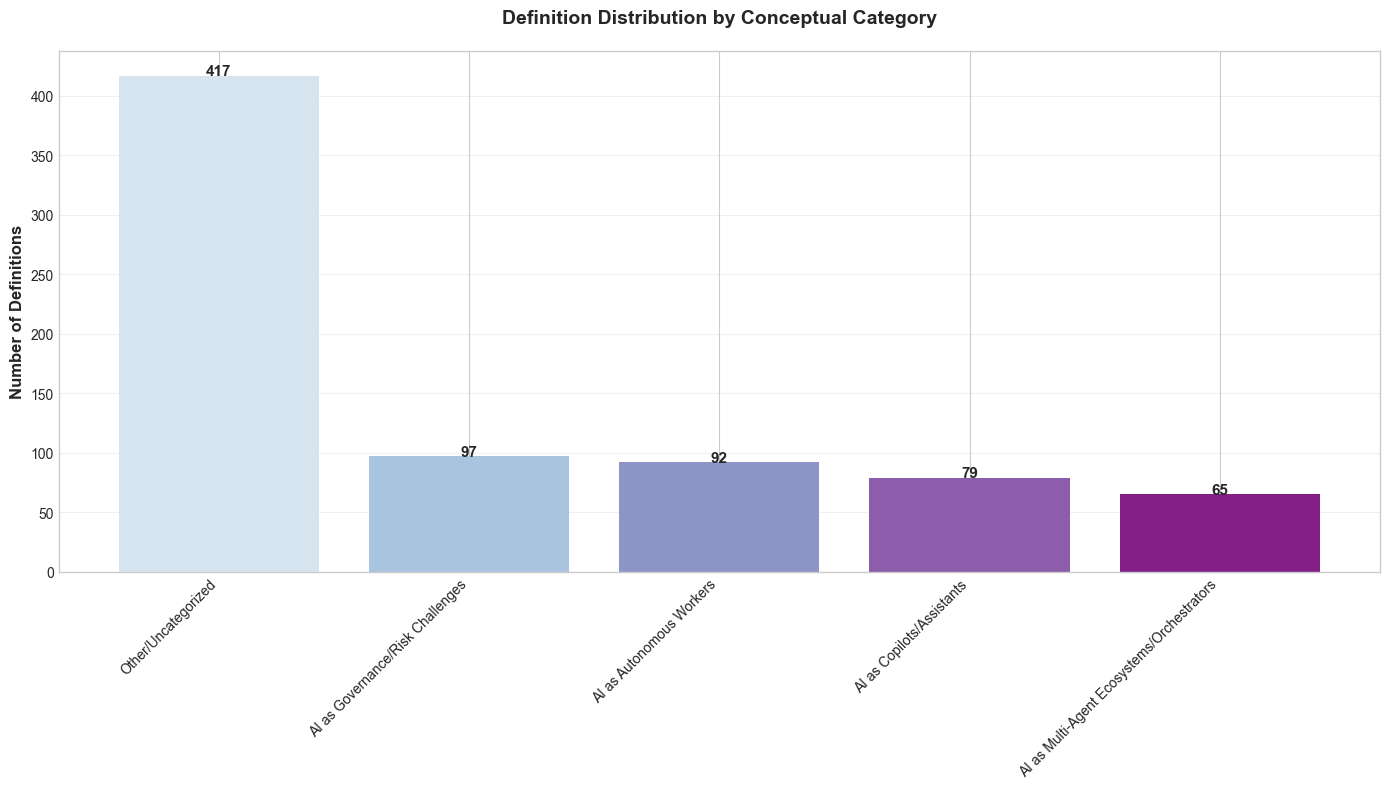

Graph saved to: c:\Users\antoi\Desktop\project_datascience\language-of-autonomy\data\processed\taxonomy\taxonomy_distribution.png


In [20]:
# Count definitions per category
category_counts = df_definitions[category_col].value_counts()

# Create mapping to full labels
category_labels = {cat_id: TAXONOMY_CATEGORIES[cat_id]['label'] 
                  for cat_id in category_counts.index}
category_counts.index = category_counts.index.map(category_labels)

# Plotting
fig, ax = plt.subplots(figsize=(14, 8))

colors = sns.color_palette('BuPu', len(category_counts))
bars = ax.bar(range(len(category_counts)), category_counts.values, 
             color=colors, linewidth=1.5)

ax.set_xticks(range(len(category_counts)))
ax.set_xticklabels(category_counts.index, rotation=45, ha='right', fontsize=10)
ax.set_ylabel('Number of Definitions', fontsize=12, fontweight='bold')
ax.set_title('Definition Distribution by Conceptual Category', 
            fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3)

for i, (bar, count) in enumerate(zip(bars, category_counts.values)):
    ax.text(i, count + 0.5, str(count), ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(TAXONOMY_DIR / 'taxonomy_distribution.png', bbox_inches='tight')
plt.show()

print(f"Graph saved to: {TAXONOMY_DIR / 'taxonomy_distribution.png'}")

### Distribution per source type

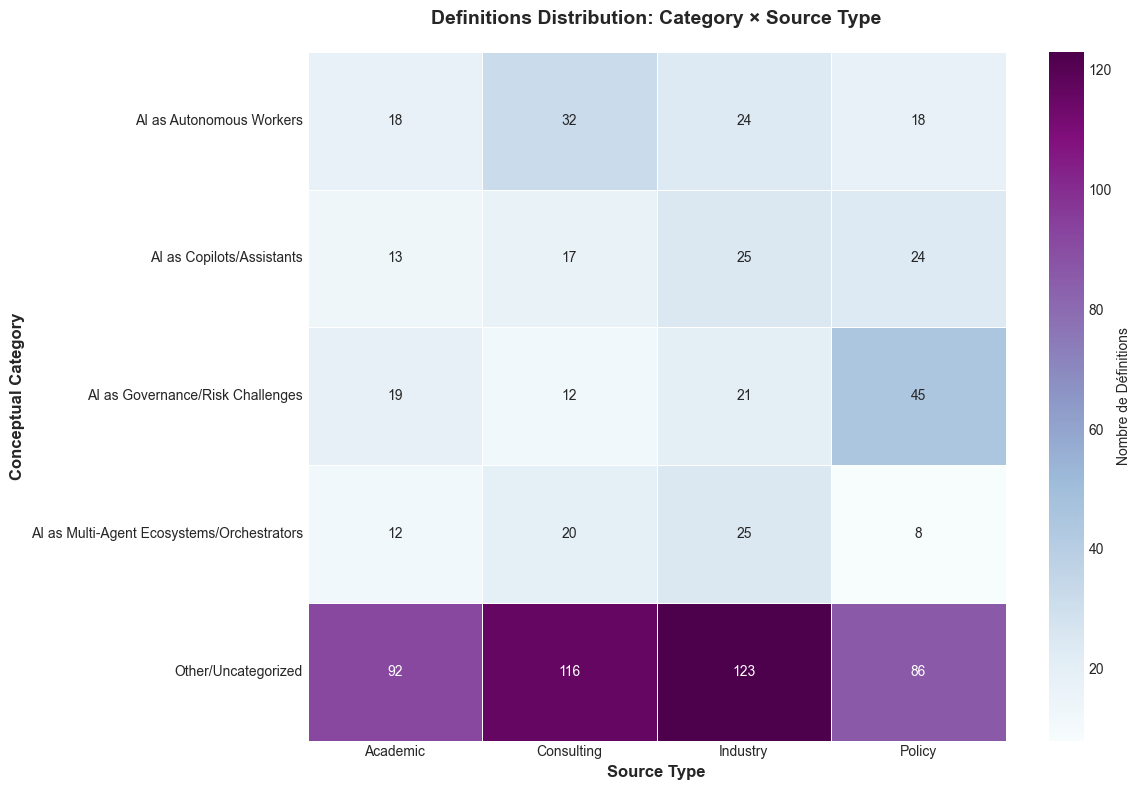

Heatmap saved to: c:\Users\antoi\Desktop\project_datascience\language-of-autonomy\data\processed\taxonomy\taxonomy_by_source_heatmap.png


In [21]:
#  create matrix category × source type
cross_tab = pd.crosstab(
    df_definitions[category_col].map(lambda x: TAXONOMY_CATEGORIES[x]['label']),
    df_definitions['source_type']
)

# plotting
fig, ax = plt.subplots(figsize=(12, 8))

sns.heatmap(cross_tab, annot=True, fmt='d', cmap='BuPu', 
           linewidths=0.5, cbar_kws={'label': 'Nombre de Définitions'}, ax=ax)

ax.set_xlabel('Source Type', fontsize=12, fontweight='bold')
ax.set_ylabel('Conceptual Category', fontsize=12, fontweight='bold')
ax.set_title('Definitions Distribution: Category × Source Type', 
            fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig(TAXONOMY_DIR / 'taxonomy_by_source_heatmap.png', bbox_inches='tight')
plt.show()

print(f"Heatmap saved to: {TAXONOMY_DIR / 'taxonomy_by_source_heatmap.png'}")

### Treemap

In [22]:
treemap_data = []

for cat_id, cat_info in TAXONOMY_CATEGORIES.items():
    count = (df_definitions[category_col] == cat_id).sum()
    if count > 0:
        treemap_data.append({
            'category': cat_info['label'],
            'count': count,
            'parent': 'Agentic AI Definitions'
        })
        
        for source_type in df_definitions['source_type'].unique():
            source_count = ((df_definitions[category_col] == cat_id) & 
                          (df_definitions['source_type'] == source_type)).sum()
            if source_count > 0:
                treemap_data.append({
                    'category': f"{source_type} ({source_count})",
                    'count': source_count,
                    'parent': cat_info['label']
                })

df_treemap=pd.DataFrame(treemap_data)

In [23]:
# Add root node
root_count = df_definitions.shape[0]
df_treemap = pd.concat([
    pd.DataFrame([{'category': 'Agentic AI Definitions', 'count': root_count, 'parent': ''}]),
    df_treemap
], ignore_index=True)

# Treemap using Plotly
fig = px.treemap(
    df_treemap,
    names='category',
    parents='parent',
    values='count',
    title='hierarchical Taxonomy of Agentic AI Definitions',
    color='count',
    color_continuous_scale='BuPu' ## RdYlBu_r
)

fig.update_layout(
    font=dict(size=14),
    title_font=dict(size=18, family='Arial Black'),
    height=700
)

fig.write_html(TAXONOMY_DIR / 'taxonomy_treemap.html')
fig.show()

print(f"Treemap saved to: {TAXONOMY_DIR / 'taxonomy_treemap.html'}")

Treemap saved to: c:\Users\antoi\Desktop\project_datascience\language-of-autonomy\data\processed\taxonomy\taxonomy_treemap.html


### Sunburst Chart

In [24]:
# Create sunburst chart
fig = px.sunburst(
    df_treemap,
    names='category',
    parents='parent',
    values='count',
    title='Definitions Taxonomy',
    color='count',
    color_continuous_scale='BuPu' ## Viridis
)

fig.update_layout(
    font=dict(size=13),
    title_font=dict(size=18, family='Arial Black'),
    height=700
)

fig.write_html(TAXONOMY_DIR / 'taxonomy_sunburst.html')
fig.show()

print(f" Sunburst saved to: {TAXONOMY_DIR / 'taxonomy_sunburst.html'}")

 Sunburst saved to: c:\Users\antoi\Desktop\project_datascience\language-of-autonomy\data\processed\taxonomy\taxonomy_sunburst.html


### Sankey Graph (Flow: Source Type → Category)

In [25]:
source_types = df_definitions['source_type'].unique()
categories = df_definitions[category_col].unique()

# Mappings
source_to_idx = {s: i for i, s in enumerate(source_types)}
cat_to_idx = {c: i + len(source_types) for i, c in enumerate(categories)}

In [26]:
# Flows
sources = []
targets = []
values = []
labels = list(source_types) + [TAXONOMY_CATEGORIES[c]['label'] for c in categories]

for _, row in df_definitions.iterrows():
    source_idx = source_to_idx[row['source_type']]
    target_idx = cat_to_idx[row[category_col]]
    
    # Check if existing flow
    try:
        idx = sources.index(source_idx)
        if targets[idx] == target_idx:
            values[idx] += 1
            continue
    except ValueError:
        pass
    
    sources.append(source_idx)
    targets.append(target_idx)
    values.append(1)

In [27]:
colors = sns.color_palette('BuPu', len(labels))
# Create Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color=['slategrey', 'lightsteelblue', 'cornflowerblue', 'lightskyblue', 
               'lavender', 'mediumpurple', 'darkorchid', 'mediumorchid'][:len(labels)]
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values
    )
)])

fig.update_layout(
    title="Flux des Définitions: Type de Source → Catégorie Conceptuelle",
    font=dict(size=12),
    height=600
)

fig.write_html(TAXONOMY_DIR / 'taxonomy_sankey.html')
fig.show()

print(f" Sankey sauvegardé: {TAXONOMY_DIR / 'taxonomy_sankey.html'}")

 Sankey sauvegardé: c:\Users\antoi\Desktop\project_datascience\language-of-autonomy\data\processed\taxonomy\taxonomy_sankey.html


## Categories comparative analysis

In [28]:
# Stats per category
for cat_id, cat_info in TAXONOMY_CATEGORIES.items():
    cat_defs = df_definitions[df_definitions[category_col] == cat_id]
    
    if len(cat_defs) == 0:
        continue
    
    print(f"{cat_info['label']}")
    
    print(f"  Total count      : {len(cat_defs)}")
    print(f"  Type distribution:")
    
    for source_type in cat_defs['source_type'].value_counts().index:
        count = (cat_defs['source_type'] == source_type).sum()
        pct = count / len(cat_defs) * 100
        print(f"    • {source_type:15} : {count:2} ({pct:5.1f}%)")

AI as Copilots/Assistants
  Total count      : 79
  Type distribution:
    • Industry        : 25 ( 31.6%)
    • Policy          : 24 ( 30.4%)
    • Consulting      : 17 ( 21.5%)
    • Academic        : 13 ( 16.5%)
AI as Autonomous Workers
  Total count      : 92
  Type distribution:
    • Consulting      : 32 ( 34.8%)
    • Industry        : 24 ( 26.1%)
    • Policy          : 18 ( 19.6%)
    • Academic        : 18 ( 19.6%)
AI as Multi-Agent Ecosystems/Orchestrators
  Total count      : 65
  Type distribution:
    • Industry        : 25 ( 38.5%)
    • Consulting      : 20 ( 30.8%)
    • Academic        : 12 ( 18.5%)
    • Policy          :  8 ( 12.3%)
AI as Governance/Risk Challenges
  Total count      : 97
  Type distribution:
    • Policy          : 45 ( 46.4%)
    • Industry        : 21 ( 21.6%)
    • Academic        : 19 ( 19.6%)
    • Consulting      : 12 ( 12.4%)
Other/Uncategorized
  Total count      : 417
  Type distribution:
    • Industry        : 123 ( 29.5%)
    • Consulti

## Summary for report

In [29]:
summary_text = f"""
MINI-TAXONOMY OF AGENTIC AI DEFINITIONS
{'='*70}

METHODOLOGY
{'-'*70}
• Semi-automatic extraction: {len(df_candidates)} candidate definitions
• Manual validation: {len(df_definitions)} definitions
• Categorization: 4 main conceptual categories

RESULTS
{'-'*70}
"""

for cat_id, cat_info in TAXONOMY_CATEGORIES.items():
    if cat_id == 'other':
        continue
    
    count = (df_definitions[category_col] == cat_id).sum()
    pct = count / len(df_definitions) * 100 if len(df_definitions) > 0 else 0
    
    summary_text += f"\n{cat_info['label']}: {count} definitions ({pct:.1f}%)\n"
    summary_text += f"  {cat_info['description']}\n"

summary_text += f"\n{'-'*70}\n"
summary_text += "KEY INSIGHTS\n"
summary_text += f"{'-'*70}\n"

# Identify dominant category
dominant_cat = df_definitions[category_col].value_counts().idxmax()
dominant_count = df_definitions[category_col].value_counts().max()
dominant_pct = dominant_count / len(df_definitions) * 100

summary_text += f"\n• Dominant category: {TAXONOMY_CATEGORIES[dominant_cat]['label']} ({dominant_pct:.1f}%)\n"

# Analyze per source type
summary_text += "\n• Differences per source type:\n"
for source_type in df_definitions['source_type'].unique():
    source_defs = df_definitions[df_definitions['source_type'] == source_type]
    if len(source_defs) > 0:
        top_cat = source_defs[category_col].value_counts().idxmax()
        summary_text += f"  - {source_type}: favors '{TAXONOMY_CATEGORIES[top_cat]['label']}'\n"

print(summary_text)


MINI-TAXONOMY OF AGENTIC AI DEFINITIONS

METHODOLOGY
----------------------------------------------------------------------
• Semi-automatic extraction: 750 candidate definitions
• Manual validation: 750 definitions
• Categorization: 4 main conceptual categories

RESULTS
----------------------------------------------------------------------

AI as Copilots/Assistants: 79 definitions (10.5%)
  AI agents that augment human work, provide suggestions, collaborate with users

AI as Autonomous Workers: 92 definitions (12.3%)
  AI agents that independently execute tasks with minimal human intervention

AI as Multi-Agent Ecosystems/Orchestrators: 65 definitions (8.7%)
  AI systems coordinating multiple agents, workflows, or complex processes

AI as Governance/Risk Challenges: 97 definitions (12.9%)
  AI agents framed through ethical, regulatory, or risk management lens

----------------------------------------------------------------------
KEY INSIGHTS
----------------------------------------

In [30]:
summary_file = TAXONOMY_DIR / 'taxonomy_summary.txt'
with open(summary_file, 'w', encoding='utf-8') as f:
    f.write(summary_text)

print(f"\nSummary saved to: {summary_file}")


Summary saved to: c:\Users\antoi\Desktop\project_datascience\language-of-autonomy\data\processed\taxonomy\taxonomy_summary.txt


## Save results

In [31]:
# Defs with categories
df_definitions.to_csv(TAXONOMY_DIR / 'definitions_categorized.csv', 
                     index=False, encoding='utf-8')
print(f"Categorized definitions saved to: {TAXONOMY_DIR / 'definitions_categorized.csv'}")

Categorized definitions saved to: c:\Users\antoi\Desktop\project_datascience\language-of-autonomy\data\processed\taxonomy\definitions_categorized.csv


In [32]:
# Table
report_table = []
for cat_id, cat_info in TAXONOMY_CATEGORIES.items():
    if cat_id == 'other':
        continue
    
    cat_defs = df_definitions[df_definitions[category_col] == cat_id]
    
    for _, row in cat_defs.iterrows():
        report_table.append({
            'Category': cat_info['label'],
            'Report': row['filename'],
            'Source_Type': row['source_type'],
            'Definition_Excerpt': row['text'][:200] + '...' if len(row['text']) > 200 else row['text']
        })

df_report_table = pd.DataFrame(report_table)
df_report_table.to_csv(TAXONOMY_DIR / 'taxonomy_table_for_report.csv', 
                       index=False, encoding='utf-8')
print(f"Table saved to: {TAXONOMY_DIR / 'taxonomy_table_for_report.csv'}")

Table saved to: c:\Users\antoi\Desktop\project_datascience\language-of-autonomy\data\processed\taxonomy\taxonomy_table_for_report.csv


In [33]:
# Aggregated stats
stats = {
    'total_definitions': len(df_definitions),
    'num_categories': len([c for c in TAXONOMY_CATEGORIES.keys() if c != 'other']),
    'category_distribution': {
        TAXONOMY_CATEGORIES[cat]['label']: int((df_definitions[category_col] == cat).sum())
        for cat in TAXONOMY_CATEGORIES.keys()
    },
    'by_source_type': {}
}

for source_type in df_definitions['source_type'].unique():
    source_defs = df_definitions[df_definitions['source_type'] == source_type]
    stats['by_source_type'][source_type] = {
        'total': len(source_defs),
        'distribution': {
            TAXONOMY_CATEGORIES[cat]['label']: int((source_defs[category_col] == cat).sum())
            for cat in TAXONOMY_CATEGORIES.keys()
        }
    }

with open(TAXONOMY_DIR / 'taxonomy_statistics.json', 'w') as f:
    json.dump(stats, f, indent=2)

print(f"JSON stats saved to: {TAXONOMY_DIR / 'taxonomy_statistics.json'}")

JSON stats saved to: c:\Users\antoi\Desktop\project_datascience\language-of-autonomy\data\processed\taxonomy\taxonomy_statistics.json


## Texte template for report

In [35]:
print(df_definitions.columns)

Index(['filename', 'source_type', 'text', 'context', 'suggested_category',
       'category_confidence', 'final_category', 'notes', 'keep'],
      dtype='object')


In [36]:
df_definitions['doc_id'] = df_definitions['filename'].map(
    lambda x: next((doc_id for doc_id in df_candidates['doc_id'] if metadata[doc_id]['filename'] == x), None))

In [37]:
template = f"""
### Mini-Taxonomy of Definitions of "Agentic AI"

A hybrid qualitative-quantitative analysis was conducted to extract and 
categorize explicit definitions of "agentic AI" across the corpus. The 
methodology combined:

1. **Semi-automatic extraction**: Pattern matching identified {len(df_candidates)} 
   candidate definitions containing key terms ("agentic AI", "AI agents", 
   "autonomous agents") and definitional markers ("is defined as", "refers to").

2. **Manual validation**: Each candidate was manually reviewed, resulting in 
   {len(df_definitions)} validated definitions spanning {len(df_definitions['doc_id'].unique())} 
   reports.

3. **Conceptual categorization**: Definitions were grouped into four primary 
   conceptual frames:

"""

for cat_id in ['copilot', 'autonomous_worker', 'orchestrator', 'governance']:
    cat_info = TAXONOMY_CATEGORIES[cat_id]
    count = (df_definitions[category_col] == cat_id).sum()
    pct = count / len(df_definitions) * 100 if len(df_definitions) > 0 else 0
    
    template += f"\n**{cat_info['label']}** ({pct:.1f}%)\n"
    template += f"{cat_info['description']}\n"

template += f"""
#### Results and Interpretation

Figure X presents the distribution of definitions across conceptual categories. 
The dominant frame is **{TAXONOMY_CATEGORIES[dominant_cat]['label']}** ({dominant_pct:.1f}%), 
suggesting that the prevailing discourse conceptualizes agentic AI as 
{TAXONOMY_CATEGORIES[dominant_cat]['description'].lower()}.

**Institutional differences** (Figure Y - Heatmap) reveal:

"""

for source_type in df_definitions['source_type'].unique():
    source_defs = df_definitions[df_definitions['source_type'] == source_type]
    if len(source_defs) > 0:
        top_cat = source_defs[category_col].value_counts().idxmax()
        top_pct = (source_defs[category_col] == top_cat).sum() / len(source_defs) * 100
        template += f"- **{source_type}**: {top_pct:.0f}% frame agentic AI as '{TAXONOMY_CATEGORIES[top_cat]['label']}'\n"

template += f"""
**Key insight**: The taxonomy exposes conceptual fragmentation in how agentic 
AI is defined. While some actors emphasize augmentation (copilots), others 
stress full autonomy (autonomous workers) or systemic complexity (orchestrators). 
This definitional ambiguity poses challenges for standardization and may lead 
to misaligned adoption strategies across organizations.

**Table 1** (see Appendix) provides the complete taxonomy with representative 
definitions from each category and source type.
"""

print(template)

with open(TAXONOMY_DIR / 'report_template.txt', 'w', encoding='utf-8') as f:
    f.write(template)

print(f"\nTemplate saved to: {TAXONOMY_DIR / 'report_template.txt'}")


### Mini-Taxonomy of Definitions of "Agentic AI"

A hybrid qualitative-quantitative analysis was conducted to extract and 
categorize explicit definitions of "agentic AI" across the corpus. The 
methodology combined:

1. **Semi-automatic extraction**: Pattern matching identified 750 
   candidate definitions containing key terms ("agentic AI", "AI agents", 
   "autonomous agents") and definitional markers ("is defined as", "refers to").

2. **Manual validation**: Each candidate was manually reviewed, resulting in 
   750 validated definitions spanning 19 
   reports.

3. **Conceptual categorization**: Definitions were grouped into four primary 
   conceptual frames:


**AI as Copilots/Assistants** (10.5%)
AI agents that augment human work, provide suggestions, collaborate with users

**AI as Autonomous Workers** (12.3%)
AI agents that independently execute tasks with minimal human intervention

**AI as Multi-Agent Ecosystems/Orchestrators** (8.7%)
AI systems coordinating multiple agen

## Summary

**Completed analysis:**
- Semi-automated extraction of definitions (pattern matching)
- Classification into 4 conceptual categories
- Manual validation (CSV file for revision)
- Comparative analysis by source type
- Multiple visualizations (bar, heatmap, treemap, sunburst, sankey)

**Generated files:**
- 5 PNG/HTML vizualisations
- 3 CSV files (candidates, definitions, table report)
- 2 JSON files (statistics)
- 2 TXT files (summary, template)

**Visuals for report:**
1. `taxonomy_distribution.png` - Global distribution
2. `taxonomy_by_source_heatmap.png` - Heatmap per source
3. `taxonomy_treemap.html` - Interactive hierarchical view
4. `taxonomy_table_for_report.csv` - Complete table

**Key insights:**
- Conceptual fragmentation of definitions
- Narrative differences between source types
- Dominance of a particular framework (to interpret)

In [39]:
print("STEP 5 FINISHED SUCCESSFULLY!")
print(f"\n Mini-taxonomy of definitions summary:")
print(f"  • Extracted definitions    : {len(df_candidates)} candidates")
print(f"  • Validated definitions    : {len(df_definitions)}")
print(f"  • Conceptual categories    : 4 principales")
print(f"  • Documents                : {len(df_definitions['doc_id'].unique())}")
print(f"  • Sources types            : {len(df_definitions['source_type'].unique())}")
print(f"\nAll files saved to: {TAXONOMY_DIR}")

STEP 5 FINISHED SUCCESSFULLY!

 Mini-taxonomy of definitions summary:
  • Extracted definitions    : 750 candidates
  • Validated definitions    : 750
  • Conceptual categories    : 4 principales
  • Documents                : 19
  • Sources types            : 4

All files saved to: c:\Users\antoi\Desktop\project_datascience\language-of-autonomy\data\processed\taxonomy
